In [58]:
import polars.selectors as cs
import numpy as np

import polars as pl

import matplotlib.pyplot as plt

In [59]:
def hist_of_numerical_values(df: pl.DataFrame):
    """
    Generates histograms for all numerical columns in a Polars DataFrame.

    Args:
        df: The Polars DataFrame.

    Returns:
        A dictionary where keys are column names and values are the histogram data.
    """
    histograms = {}
    for col_name in df.columns:
        if df[col_name].dtype in [pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64, pl.Float32, pl.Float64]:
            hist_data = df[col_name].hist()
            histograms[col_name] = hist_data
    return histograms

In [60]:
index_cols = {
    20: []
}
scale_required = set([4, 5, 6, 7, 9, 12, 13, 17, 19, 21, 22])
# not 8, 14
# skip 3, skip 20
queries_to_run = [20]

In [61]:
query_ind = 20
null_info = {}
orig = pl.read_csv(f'unnoised/q{query_ind}.csv')
noised = pl.read_json(f'outputs/ap-duckdb-q{query_ind}-customer-step3/output.json')
orig = orig.with_row_index(name="rank")
noised = noised.with_row_index(name="rank")
merged_df = orig.join(noised, suffix='_noised',  on="rank")

In [62]:
merged_df[7]['s_name_noised'].to_list()[0]

[None]

In [63]:
suffix1 = ''
suffix2 = '_noised'
cols_with_suffixes = [col for col in merged_df.columns if suffix1 in col or suffix2 in col]
base_names = set([col.replace(suffix1, '').replace(suffix2, '') for col in cols_with_suffixes])
for base_name in base_names:
    nulls_exist = False
    null_inds, null_vals = [], []

    orig = base_name + suffix1
    noised = base_name + suffix2
    if orig in merged_df.columns and noised in merged_df.columns:
        rel_errors = []
        for ind in range(len(merged_df[orig])):
            releases = merged_df[noised][ind].to_list()
            filtered_releases = [x for x in releases if x is not None]
            if len(filtered_releases) == 0:
                rel_errors.append(None)
                continue
            actual = merged_df[orig][ind]
            pct_agreement = 100*releases.count(actual) / len(releases)
            rel_errors.append(pct_agreement)
        merged_df = merged_df.with_columns(pl.Series('pct_agreement_' + base_name, rel_errors))
        num_outputs = len(list(merged_df[noised]))
        for ind in range(num_outputs):
            full_list = [x for x in list(merged_df[noised][ind]) if x is not None]
            if len(full_list) < 100:
                nulls_exist = True
                null_inds.append(ind)
                null_vals.append(100-len(full_list))
                print(query_ind, ind)
    null_info[base_name] = (nulls_exist, null_inds, null_vals)


20 4
20 5
20 6
20 7
20 8
20 3
20 4
20 5
20 6
20 7
20 8


In [64]:
merged_df

rank,s_name,s_address,s_name_noised,s_address_noised,pct_agreement_s_name,pct_agreement_s_address
u32,str,str,list[str],list[str],f64,f64
0,"""Supplier#000000157""","""1EmkCApL5iF""","[""Supplier#000000197"", ""Supplier#000000378"", … ""Supplier#000000197""]","[""mLPJtpu4wOc cSFzBR"", ""UQR8bUA4V2HxVbw9K"", … ""1EmkCApL5iF""]",29.0,33.0
1,"""Supplier#000000197""","""3oYqODDUGH3XsHXmPuzYHW5NLU3,ON…","[""Supplier#000000530"", ""Supplier#000000530"", … ""Supplier#000000197""]","[""3oYqODDUGH3XsHXmPuzYHW5NLU3,ONZl"", ""8Lp0QWPLFXrJrX1sTWkAEdzUsh5ke"", … ""UQR8bUA4V2HxVbw9K""]",20.0,15.0
2,"""Supplier#000000287""","""UQR8bUA4V2HxVbw9K""","[""Supplier#000000287"", ""Supplier#000000557"", … ""Supplier#000000378""]","[""mLPJtpu4wOc cSFzBR"", ""8Lp0QWPLFXrJrX1sTWkAEdzUsh5ke"", … ""IH,v63JRgXMkVhJOJ Gxur0W""]",18.0,10.0
3,"""Supplier#000000378""","""mLPJtpu4wOc cSFzBR""","[""Supplier#000000530"", ""Supplier#000000729"", … ""Supplier#000000555""]","[""0BvoewCPg2scOEfuL93FRKqSxHmdhw1"", ""JHRSOterYgt4MTNo7cupTzA,6MoNw 4"", … ""CAOGYCBtTVT7aB1p6qHbxF6VVhXaHLgTpI""]",22.0,12.121212
4,"""Supplier#000000530""","""0BvoewCPg2scOEfuL93FRKqSxHmdhw…","[""Supplier#000000555"", ""Supplier#000000557"", … ""Supplier#000000555""]","[""IH,v63JRgXMkVhJOJ Gxur0W"", ""JHRSOterYgt4MTNo7cupTzA,6MoNw 4"", … ""JHRSOterYgt4MTNo7cupTzA,6MoNw 4""]",16.129032,22.44898
5,"""Supplier#000000555""","""8Lp0QWPLFXrJrX1sTWkAEdzUsh5ke""","[""Supplier#000000555"", ""Supplier#000000935"", … ""Supplier#000000555""]","[""JHRSOterYgt4MTNo7cupTzA,6MoNw 4"", ""IH,v63JRgXMkVhJOJ Gxur0W"", … ""JHRSOterYgt4MTNo7cupTzA,6MoNw 4""]",21.428571,30.588235
6,"""Supplier#000000557""","""IH,v63JRgXMkVhJOJ Gxur0W""","[""Supplier#000000557"", ""Supplier#000000935"", … ""Supplier#000000557""]","[""IH,v63JRgXMkVhJOJ Gxur0W"", ""CAOGYCBtTVT7aB1p6qHbxF6VVhXaHLgTpI"", … ""JHRSOterYgt4MTNo7cupTzA,6MoNw 4""]",34.0,39.344262
7,"""Supplier#000000729""","""CAOGYCBtTVT7aB1p6qHbxF6VVhXaHL…",[null],[null],null,null
8,"""Supplier#000000935""","""JHRSOterYgt4MTNo7cupTzA,6MoNw …",[null],[null],null,null


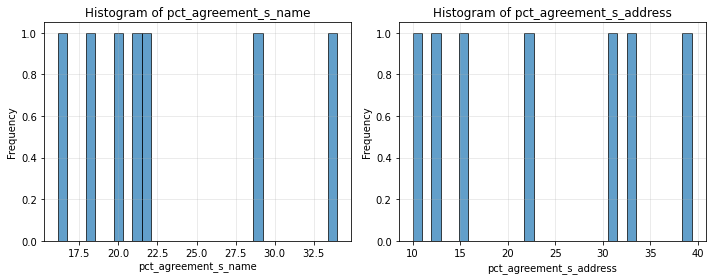

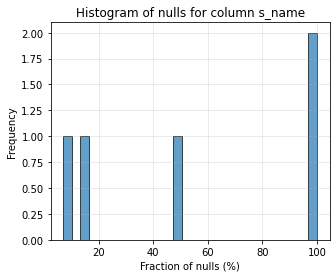

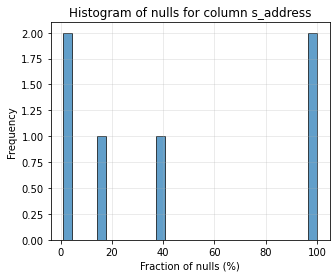

In [65]:

# Get columns that start with 'pct_diff'
pct_diff_cols = [col for col in merged_df.columns if col.startswith('pct_agreement')]

# Create subplots based on number of pct_diff columns
n_cols = len(pct_diff_cols)
fig, axes = plt.subplots(1, n_cols, figsize=(5*n_cols, 4))

# Handle case where there's only one column (axes won't be a list)
if n_cols == 1:
    axes = [axes]

# Create histogram for each column
for i, col in enumerate(pct_diff_cols):
    # Convert to pandas for easier plotting, or use polars plot method
    values = merged_df[col].to_pandas()

    axes[i].hist(values, bins=30, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'figs/mi_1_2/q{query_ind}_{col}_hist.png', facecolor='white', bbox_inches='tight')

for base in null_info:
    (nulls_exist, null_inds, null_vals) = null_info[base]
    if nulls_exist:
        fig, axes = plt.subplots(1, 1, figsize=(5, 4))
        axes = [axes]
        axes[0].hist(null_vals, bins=30, alpha=0.7, edgecolor='black')
        axes[0].set_title(f'Histogram of nulls for column {base}')
        axes[0].set_xlabel('Fraction of nulls (%)')
        axes[0].set_ylabel('Frequency')
        axes[0].grid(True, alpha=0.3)
        plt.savefig(f'figs/mi_1_2/q{query_ind}_{base}_nulls.png', facecolor='white', bbox_inches='tight')